## **Mengimpor libaries** 

In [1]:
# Mengimpor libaries pandas,numpy dan json untuk memproses data dalam format JSON
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

# import warning to ignore warning
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## **Install mysql connector**

In [2]:
# import libraries
import mysql.connector
from mysql.connector import Error

In [3]:
# Define MySQL details
host   = 'okegarden-laravel-prod-db-2024-11-15-0200.cgwhhgh85mr3.ap-southeast-3.rds.amazonaws.com'
port   = '3306'
user   = 'intern_mes'
passwd = 'sdfDFLES342982Ddlsdksd'
databs = 'okegarden_laravel_prod_db'

In [4]:
# function to fetch data from database, the connection is closed after use.
def fetch_data(host_name, port_name, user_name, user_password, db_name, query, params=None):
    try:
        # use with to ensure the connection is closed after use
        with mysql.connector.connect(
            host=host_name,
            port=port_name,
            user=user_name,
            password=user_password,
            database=db_name
        ) as connection:
            data = pd.read_sql(query, connection, params=params) # read the query to dataframe format
            return data

    except Error as e:
        print(f"Error while connecting to MySQL or fetching data: {e}")
        return None

In [5]:
query = """

WITH order_design_status AS (
    SELECT
        id_design_finish AS id_design, 
        status AS status_order_design,
        created_at AS start_time
    FROM
        order_design
    WHERE
        status = 'finish'
),
order_garden_status AS (
    SELECT
        id_design AS id_design,
        status AS status_order_garden,
        created_at AS end_time
    FROM
        order_garden 
    WHERE
        status = 'finish'
),
durations AS (
    SELECT
        ds.id_design,
        TIMESTAMPDIFF(HOUR, ds.start_time, gs.end_time) AS duration_hours,
        YEAR(ds.start_time) AS year,
        MONTH(ds.start_time) AS month
    FROM
        order_design_status ds
    INNER JOIN
        order_garden_status gs 
    ON 
        ds.id_design = gs.id_design
    WHERE
        ds.start_time IS NOT NULL AND gs.end_time IS NOT NULL
)
select * from durations;


"""
design_build = fetch_data(host, port, user, passwd, databs, query)

Kode ini digunakan untuk menganalisis data dari dua tabel, yaitu **order design** dan **order garden**. Tujuannya adalah untuk mencari **order cycle time** dari tahap desain hingga tahap pembangunan. Berikut adalah langkah-langkah yang dilakukan dalam kode ini:

- **Mengambil Data**: Kode ini pertama-tama mengambil data dari tabel yang relevan, yaitu `order design` dan `order garden`.
  
- **Menghitung Waktu Siklus**: Setelah data diambil, kode ini menghitung waktu siklus pesanan dengan mengukur selisih waktu antara tahap desain dan tahap pembangunan.

- **Menampilkan Hasil**: Hasil dari perhitungan waktu siklus kemudian ditampilkan untuk analisis lebih lanjut.


## **Explore Data**

In [6]:
# Menampilkan 5 baris pertama data.
design_build.head()

,id_design,duration_hours,year,month
0,214,601,2024,4
1,227,1412,2024,5
2,232,2774,2024,5
3,255,1080,2024,5
4,260,1055,2024,5


In [7]:
design_build.tail()

,id_design,duration_hours,year,month
67,534,820,2024,9
68,543,539,2024,10
69,542,225,2024,10
70,556,261,2024,10
71,559,82,2024,10


In [8]:
design_build.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id_design       72 non-null     int64
 1   duration_hours  72 non-null     int64
 2   year            72 non-null     int64
 3   month           72 non-null     int64
dtypes: int64(4)
memory usage: 2.4 KB


## **Data Cleaning**

#### Pada langkah ini, kita berupaya mengidentifikasi baris dan kolom yang berisi nilai yang hilang

In [9]:
# Check null values 
design_build.isnull().sum()

id_design         0
duration_hours    0
year              0
month             0
dtype: int64

In [10]:
# Mencari dan memeriksa duplikat dalam DataFrame 'order_cycletime'
duplicates = design_build[design_build.duplicated()]
if duplicates.empty:
    print("Tidak ada duplikat pada seluruh kolom.")
else:
    print(f"Total duplicate rows (all columns): {len (duplicates)}")
    print("\nDuplicate Rows (all columns):")
    print(duplicates)

Tidak ada duplikat pada seluruh kolom.


Berdasarkan hasil pemeriksaan duplikasi dengan menggunakan metode .duplicated(), tidak ditemukan data yang duplikat pada seluruh kolom di DataFrame order_cycletime.

## **Data Transformation**

##### Pada tahap ini, kami melakukan serangkaian transformasi data yang bertujuan untuk mempersiapkan dataset agar lebih siap untuk analisis mendalam.  
##### Transformasi ini mencakup dua aspek utama: pembuatan kolom baru dan pengubahan tipe data.

In [11]:
design_build = design_build.groupby('month')['duration_hours'].mean().reset_index()
design_build['time_interval_status_days'] = design_build['duration_hours'].apply(lambda x: f"{int(x // 24)} Hari")
design_build

,month,duration_hours,time_interval_status_days
0,4,601.000000,25 Hari
1,5,1113.555556,46 Hari
2,6,552.923077,23 Hari
3,7,405.294118,16 Hari
4,8,584.928571,24 Hari
5,9,683.571429,28 Hari
6,10,276.750000,11 Hari


In [12]:
design_build.dtypes

month                          int64
duration_hours               float64
time_interval_status_days     object
dtype: object

## **Analysis and Visualization**
Tahap "Analysis and Visualization" (Analisis dan Visualisasi) adalah langkah krusial dalam proses eksplorasi data. Dalam konteks ini, kita berfokus pada dua aspek utama: ringkasan **statistik (summary statistics)** dan **visualisasi data**

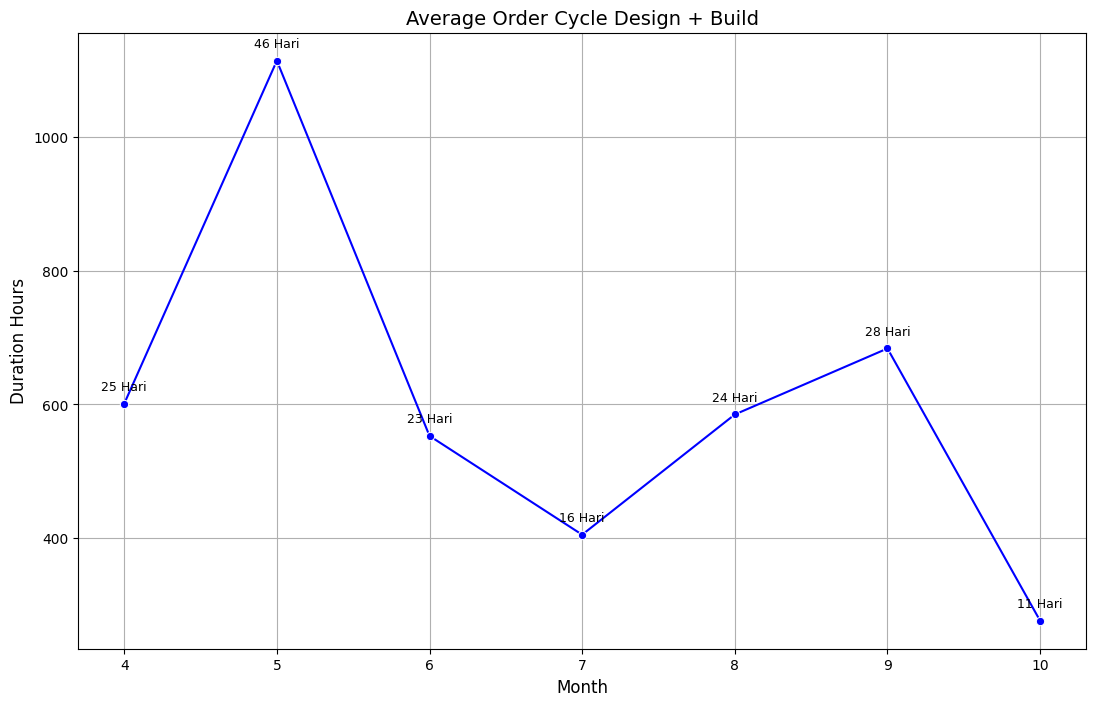

In [13]:
plt.figure(figsize=(13, 8))
sns.lineplot(data=design_build, x='month', y='duration_hours', marker='o', color='blue', ci=None)

# Tambahkan label dari kolom 'time_interval_status_days' di dekat setiap titik
for x, y, label in zip(design_build['month'], design_build['duration_hours'], design_build['time_interval_status_days']):
    plt.text(x, y + 20, label, color='black', ha='center', fontsize=9)

# Tambahkan judul dan label
plt.title('Average Order Cycle Design + Build', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Duration Hours', fontsize=12)
plt.grid(True)

# Tampilkan grafik
plt.show()

### Grafik di atas menggambarkan rata-rata waktu yang dibutuhkan untuk menyelesaikan satu siklus pesanan (dari tahap desain hingga pembangunan) setiap bulannya.

- **Fluktuasi Waktu**: Waktu yang dibutuhkan untuk menyelesaikan satu pesanan mengalami fluktuasi yang cukup signifikan dari bulan ke bulan.  
- **Puncak**: Waktu yang paling lama dibutuhkan adalah pada bulan 5, yaitu sekitar 46 hari.  
- **Titik Terendah**: Waktu yang paling singkat dibutuhkan adalah pada bulan 10, yaitu sekitar 1 hari.  
- **Tren Umum**: Secara umum, ada kecenderungan penurunan waktu penyelesaian dari bulan 5 hingga bulan 10, meskipun terdapat beberapa fluktuasi di antaranya.  